<a href="https://colab.research.google.com/github/lukehartfield/Integer-Programming-Optimization/blob/main/Optimization_Project_2_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gurobipy

In [ ]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import math
from gurobipy import Model, GRB, quicksum

***Questions 1-3
Linear Program - Optimal Budget Allocation***

In [ ]:
df_roi = pd.read_csv("roi_company1.csv")

In [ ]:
# Amounts are in MILLIONS of dollars (so budget=10 means $10M)
# --- Parameters (change if needed) ---
budget = 10.0        # total budget in millions
platform_cap = 3.0   # per-platform max in millions
bigM = budget        # big-M for "infinite" tiers (safe because total budget <= budget)

# Compute tier widths (maximum amount that can be placed in that tier)
def tier_width(row):
    if np.isfinite(row['UpperBound']):
        return max(0.0, row['UpperBound'] - row['LowerBound'])
    else:
        return bigM  # allow up to the whole budget for an "infinite" tier; platform cap will restrict
df_roi['Width'] = df_roi.apply(tier_width, axis=1)

# Build model
m = gp.Model()

# Decision vars: amount invested in each tier (millions)
vars_by_index = {}
for idx, row in df_roi.iterrows():
    name = f"x_{int(idx)}_{row['Platform']}_t{int(row['Tier'])}"
    ub = row['Width']
    # some widths could be zero if Upper==Lower; skip creating vars that can't take anything
    if ub <= 0:
        v = m.addVar(lb=0.0, ub=0.0, name=name)
    else:
        v = m.addVar(lb=0.0, ub=ub, name=name)
    vars_by_index[idx] = v


# Objective: maximize total return = sum(ROI * invested_in_tier)
obj_expr = gp.quicksum(df_roi.loc[idx, 'ROI'] * vars_by_index[idx] for idx in vars_by_index)
m.setObjective(obj_expr, GRB.MAXIMIZE)

# 1) Total budget constraint
m.addConstr(gp.quicksum(vars_by_index[idx] for idx in vars_by_index) <= budget)

# Helper: platform -> list of tier indices
platform_to_indices = {}
for idx, row in df_roi.iterrows():
    platform_to_indices.setdefault(row['Platform'], []).append(idx)

# 2) Per-platform cap: total invested in each platform <= platform_cap
for platform, idx_list in platform_to_indices.items():
    m.addConstr(gp.quicksum(vars_by_index[idx] for idx in idx_list) <= platform_cap)

# Business constraints:
# a) Print + TV <= Facebook + Email
def platform_total(platform):
    idxs = platform_to_indices.get(platform, [])
    return gp.quicksum(vars_by_index[i] for i in idxs)

m.addConstr(platform_total('Print') + platform_total('TV') <= platform_total('Facebook') + platform_total('Email'))

# b) Social media (Facebook, LinkedIn, Instagram, Snapchat, Twitter) >= 2 * (SEO + AdWords)
social_platforms = ['Facebook', 'LinkedIn', 'Instagram', 'Snapchat', 'Twitter']
social_sum = gp.quicksum(platform_total(p) for p in social_platforms)
m.addConstr(social_sum >= 2.0 * (platform_total('SEO') + platform_total('AdWords')))

# Solve
m.Params.OutputFlag = 0 # tell gurobi to shut up!!
m.optimize()

# Print results
if m.status == GRB.OPTIMAL or m.status == GRB.TIME_LIMIT or m.status == GRB.SUBOPTIMAL:
    print('\n=== Optimal allocation (amounts in MILLIONS) ===')
    # Per-platform totals
    platform_alloc = {}
    for platform, idxs in platform_to_indices.items():
        total = sum(vars_by_index[i].X for i in idxs)
        platform_alloc[platform] = total
        print(f"{platform:10s}: {total:.4f} (per-tier breakdown below)")
        for i in idxs:
            invested = vars_by_index[i].X
            if invested > 1e-8:
                row = df_roi.loc[i]
                print(f"   tier {int(row['Tier'])}: {invested:.4f}  (ROI={row['ROI']:.4f}, width={row['Width']:.2f})")
    total_invested = sum(v.X for v in vars_by_index.values())
    total_return = sum(df_roi.loc[i, 'ROI'] * vars_by_index[i].X for i in vars_by_index)
    print(f"\nTotal invested: {total_invested:.4f} / {budget:.4f} (M)")
    print(f"Estimated total return: {total_return:.6f} (in MILLIONS of dollars returned)")
    # If you want dollar-level return, multiply by 1e6
else:
    print("Model did not solve to optimality. Status:", m.status)

Set parameter Username
Set parameter LicenseID to value 2699559
Academic license - for non-commercial use only - expires 2026-08-25

=== Optimal allocation (amounts in MILLIONS) ===
Print     : 0.0000 (per-tier breakdown below)
TV        : 3.0000 (per-tier breakdown below)
   tier 1: 3.0000  (ROI=0.0608, width=4.30)
SEO       : 0.0000 (per-tier breakdown below)
AdWords   : 1.0000 (per-tier breakdown below)
   tier 1: 1.0000  (ROI=0.0419, width=2.00)
Facebook  : 0.0000 (per-tier breakdown below)
LinkedIn  : 0.0000 (per-tier breakdown below)
Instagram : 3.0000 (per-tier breakdown below)
   tier 1: 2.9000  (ROI=0.0574, width=2.90)
   tier 2: 0.1000  (ROI=0.0498, width=10.00)
Snapchat  : 0.0000 (per-tier breakdown below)
Twitter   : 0.0000 (per-tier breakdown below)
Email     : 3.0000 (per-tier breakdown below)
   tier 1: 3.0000  (ROI=0.0493, width=5.90)

Total invested: 10.0000 / 10.0000 (M)
Estimated total return: 0.543640 (in MILLIONS of dollars returned)



***Question 4 Mixed Integer Program - Optimal Budget Allocation***

In [ ]:
df_roi2 = pd.read_csv("roi_company2.csv")

# -----------------------------
# SETUP (amounts in MILLIONS)
# -----------------------------
budget = 10.0        # total budget in millions
platform_cap = 3.0   # per-platform max in millions
bigM = budget        # safe big-M for "inf" tiers

# Ensure Width exists (based on df_roi2)
def tier_width(row):
    if np.isfinite(row['UpperBound']):
        return max(0.0, row['UpperBound'] - row['LowerBound'])
    else:
        return bigM  # allow up to whole budget for "inf"
df2 = df_roi2.copy()
df2['Width'] = df2.apply(tier_width, axis=1)

# -----------------------------
# BUILD MODEL FROM df_roi2 ONLY
# -----------------------------
m_mip = gp.Model() # Use a different model name for MIP
m_mip.Params.OutputFlag = 0

# Decision vars: amount invested in each tier (millions)
vars_by_index_mip = {} # Use a different variable name for MIP vars
for idx, row in df2.iterrows():
    name = f"x_{int(idx)}_{row['Platform']}_t{int(row['Tier'])}"
    ub = float(row['Width'])
    # keep same pattern as your LP
    if ub <= 0:
        v = m_mip.addVar(lb=0.0, ub=0.0, name=name)
    else:
        v = m_mip.addVar(lb=0.0, ub=ub, name=name)
    vars_by_index_mip[idx] = v

# Objective: maximize total return = sum(ROI * invested_in_tier)
obj_expr = gp.quicksum(df2.loc[idx, 'ROI'] * vars_by_index_mip[idx] for idx in vars_by_index_mip)
m_mip.setObjective(obj_expr, GRB.MAXIMIZE)

# Helper: platform -> list of tier indices (built from df_roi2)
platform_to_indices_mip = {} # Use a different name for MIP indices
for idx, row in df2.iterrows():
    platform_to_indices_mip.setdefault(row['Platform'], []).append(idx)

# -----------------------------
# SAME BUSINESS CONSTRAINTS
# -----------------------------
# 1) Total budget
m_mip.addConstr(gp.quicksum(vars_by_index_mip[idx] for idx in vars_by_index_mip) <= budget)

# 2) Per-platform cap
for platform, idx_list in platform_to_indices_mip.items():
    m_mip.addConstr(gp.quicksum(vars_by_index_mip[idx] for idx in idx_list) <= platform_cap)

# (a) Print + TV <= Facebook + Email
def platform_total_mip(p): # Use a different name for MIP platform total
    idxs = platform_to_indices_mip.get(p, [])
    return gp.quicksum(vars_by_index_mip[i] for i in idxs)

m_mip.addConstr(
    platform_total_mip('Print') + platform_total_mip('TV')
    <= platform_total_mip('Facebook') + platform_total_mip('Email')
)

# (b) Social >= 2 * (SEO + AdWords)
social_platforms = ['Facebook', 'LinkedIn', 'Instagram', 'Snapchat', 'Twitter']
social_sum = gp.quicksum(platform_total_mip(p) for p in social_platforms)
m_mip.addConstr(social_sum >= 2.0 * (platform_total_mip('SEO') + platform_total_mip('AdWords')))

# -----------------------------
# MIP ADD-ON: NO SKIPPING
# -----------------------------
# 1) Binary activation per tier
z_by_index = {}
for idx, row in df2.iterrows():
    z_by_index[idx] = m_mip.addVar(vtype=GRB.BINARY,
                               name=f"z_{int(idx)}_{row['Platform']}_t{int(row['Tier'])}")

# 2) Gate: no spend unless tier is on
for idx, row in df2.iterrows():
    m_mip.addConstr(vars_by_index_mip[idx] <= row['Width'] * z_by_index[idx],
                name=f"gate_{int(idx)}_{row['Platform']}_t{int(row['Tier'])}")

# 3) Chain (no activation skipping): if higher tier is on, lower must be on  -> z_prev >= z_next
for platform, idx_list in platform_to_indices_mip.items(): # Use platform_to_indices_mip
    idx_list_sorted = sorted(
        idx_list,
        key=lambda k: (float(df2.loc[k, 'LowerBound']), int(df2.loc[k, 'Tier']))
    )
    for prev_idx, next_idx in zip(idx_list_sorted[:-1], idx_list_sorted[1:]):
        m_mip.addConstr(z_by_index[prev_idx] >= z_by_index[next_idx],
                    name=f"order_{platform}_t{int(df2.loc[prev_idx,'Tier'])}_to_t{int(df2.loc[next_idx,'Tier'])}")

# 4) Fill-up (no spend skipping): must fully fund tier j before any spend in tier j+1
for platform, idx_list in platform_to_indices_mip.items(): # Use platform_to_indices_mip
    idx_list_sorted = sorted(
        idx_list,
        key=lambda k: (float(df2.loc[k, 'LowerBound']), int(df2.loc[k, 'Tier']))
    )
    for prev_idx, next_idx in zip(idx_list_sorted[:-1], idx_list_sorted[1:]):
        m_mip.addConstr(
            vars_by_index_mip[prev_idx] >= df2.loc[prev_idx, 'Width'] * z_by_index[next_idx],
            name=f"fill_{platform}_t{int(df2.loc[prev_idx,'Tier'])}_before_t{int(df2.loc[next_idx,'Tier'])}"
        )



# -----------------------------
# SOLVE + CLEAN REPORT
# -----------------------------
m_mip.optimize()

EPS = 1e-9
print(f"Objective (total return): {m_mip.objVal:,.6f}")
for platform, idx_list in platform_to_indices_mip.items(): # Use platform_to_indices_mip
    invested = sum(vars_by_index_mip[i].X for i in idx_list)
    tiers_on = sorted([int(df2.loc[i, 'Tier']) for i in idx_list if vars_by_index_mip[i].X > EPS])
    print(f"{platform:12s}  invested={invested:,.3f}M   tiers_on={tiers_on}")

Objective (total return): 0.452827
Print         invested=3.000M   tiers_on=[1, 2]
TV            invested=0.000M   tiers_on=[]
SEO           invested=0.000M   tiers_on=[]
AdWords       invested=2.333M   tiers_on=[1, 2]
Facebook      invested=3.000M   tiers_on=[1]
LinkedIn      invested=1.667M   tiers_on=[1]
Instagram     invested=0.000M   tiers_on=[]
Snapchat      invested=0.000M   tiers_on=[]
Twitter       invested=0.000M   tiers_on=[]
Email         invested=0.000M   tiers_on=[]


***Question 5***

In [ ]:
# Scenario 1: Objective using df_roi with allocation from df_roi2 (MIP)

# Get allocation from the MIP model (vars_by_index_mip)
# Use the platform_to_indices_mip created for df_roi2 in cell 33aHki4hS7_s
# Ensure cell 33aHki4hS7_s has been executed to define vars_by_index_mip and platform_to_indices_mip
mip_allocation = {df2.loc[idx, 'Platform']: {df2.loc[idx, 'Tier']: var.X for idx, var in vars_by_index_mip.items() if var.X > 1e-9}
                  for platform, idx_list in platform_to_indices_mip.items()}

# Calculate objective using df_roi and mip_allocation
total_return_roi1_mip_alloc = 0
for idx, row in df_roi.iterrows():
    platform = row['Platform']
    tier = row['Tier']
    roi = row['ROI']
    # Find the allocated amount for this tier in the MIP allocation
    allocated_amount = mip_allocation.get(platform, {}).get(tier, 0)
    total_return_roi1_mip_alloc += roi * allocated_amount

print(f"Objective using df_ROI with allocation from df_ROI2 (MIP): {total_return_roi1_mip_alloc:,.6f}")

# Scenario 2: Objective using df_roi2 with allocation from df_roi (LP)

# Get allocation from the LP model (vars_by_index_lp)
# Use the platform_to_indices_lp created for df_roi in cell Zb0hiaVdjlB6
# Ensure cell Zb0hiaVdjlB6 has been executed to define vars_by_index_lp and platform_to_indices_lp
lp_allocation = {df_roi.loc[idx, 'Platform']: {df_roi.loc[idx, 'Tier']: var.X for idx, var in vars_by_index.items() if var.X > 1e-9}
                 for platform, idx_list in platform_to_indices.items()}

# Calculate objective using df_roi2 and lp_allocation
total_return_roi2_lp_alloc = 0
for idx, row in df_roi2.iterrows():
    platform = row['Platform']
    tier = row['Tier']
    roi = row['ROI']
    # Find the allocated amount for this tier in the LP allocation
    allocated_amount = lp_allocation.get(platform, {}).get(tier, 0)
    total_return_roi2_lp_alloc += roi * allocated_amount

print(f"Objective using df_ROI2 with allocation from df_ROI (LP): {total_return_roi2_lp_alloc:,.6f}")

Objective using df_ROI with allocation from df_ROI2 (MIP): 0.128067
Objective using df_ROI2 with allocation from df_ROI (LP): 0.076150


***Graphs for Report***

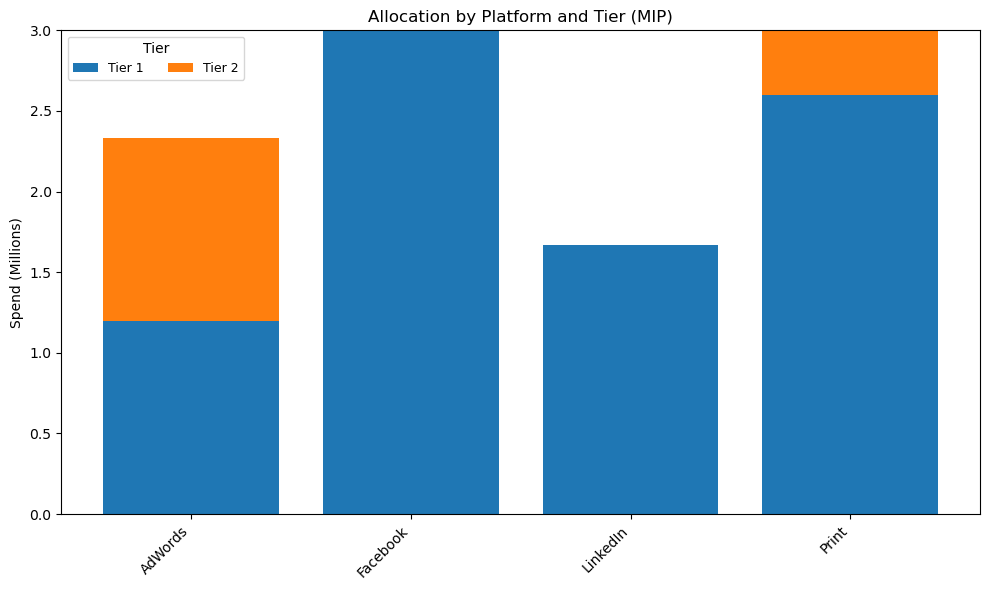


Allocation summary (for report):


,TotalSpendM,TiersOn
Platform,,
AdWords,2.333333,"[1, 2]"
Facebook,3.000000,[1]
LinkedIn,1.666667,[1]
Print,3.000000,"[1, 2]"


In [ ]:
# -----------------------------
# GRAPH: Spend by Tier per Platform (stacked bars)
# -----------------------------
import matplotlib.pyplot as plt

EPS = 1e-9

# Build a tidy allocation table from the solved model
alloc_rows = []
for platform, idx_list in platform_to_indices.items():
    for i in idx_list:
        spend = float(vars_by_index_mip[i].X)
        if spend > EPS:
            alloc_rows.append({
                "Platform": platform,
                "Tier": int(df2.loc[i, "Tier"]),
                "SpendM": spend,
                "ROI": float(df2.loc[i, "ROI"])
            })

alloc_df = pd.DataFrame(alloc_rows)

# If nothing was invested (edge case), still create an empty frame
if alloc_df.empty:
    alloc_df = pd.DataFrame(columns=["Platform", "Tier", "SpendM", "ROI"])

# Pivot to Platform x Tier for stacked plotting
spend_pivot = (
    alloc_df
    .pivot_table(index="Platform", columns="Tier", values="SpendM", aggfunc="sum", fill_value=0.0)
    .sort_index(axis=1)  # sort tiers ascending for consistent stacked order
    .sort_index(axis=0)  # sort platforms alphabetically
)

# Plot stacked bars
plt.figure(figsize=(10, 6))
bottom = np.zeros(len(spend_pivot))
x = np.arange(len(spend_pivot.index))
for tier in spend_pivot.columns:
    heights = spend_pivot[tier].values
    plt.bar(x, heights, bottom=bottom, label=f"Tier {tier}")
    bottom += heights

plt.xticks(x, spend_pivot.index, rotation=45, ha="right")
plt.ylabel("Spend (Millions)")
plt.title("Allocation by Platform and Tier (MIP)")
plt.legend(title="Tier", ncols=3, fontsize=9, title_fontsize=10)
plt.tight_layout()
# Optional: save for the report
# plt.savefig("allocation_by_platform_tiers.png", dpi=200, bbox_inches="tight")
plt.show()

# -----------------------------
# TABLE: Totals & Active Tiers (for report appendix)
# -----------------------------
totals = spend_pivot.sum(axis=1).rename("TotalSpendM")
active_tiers = (
    (spend_pivot > EPS)
    .apply(lambda row: [int(c) for c in spend_pivot.columns[row.values]], axis=1)
    .rename("TiersOn")
)
summary_tbl = pd.concat([totals, active_tiers], axis=1)
print("\nAllocation summary (for report):")
display(summary_tbl)


***Question 6:***

In [ ]:
ROI_FILE = "roi_company2.csv"
MIN_FILE = "min_amount.csv"

BUDGET_M = 10.0           # 10M total budget
CAP_PER_PLATFORM_M = 3.0  # 3M per platform cap

PRINT = "Print"; TV = "TV"; FACEBOOK = "Facebook"; EMAIL = "Email"
SOCIAL = ["Facebook", "LinkedIn", "Instagram", "Snapchat", "Twitter"]
SEARCH = ["SEO", "AdWords"]
# ---------------------------------------------------------------------

def load_roi_in_millions(path):
    """Return columns: platform, tier_idx, lower_m, upper_m, width_m, roi (decimal)."""
    df = pd.read_csv(path)
    df.columns = [c.strip().lower() for c in df.columns]
    syn = {
        "channel":"platform", "medium":"platform",
        "roi":"roi_pct", "roi%":"roi_pct", "return":"roi_pct",
        "tier":"tier", "lower":"tier_lower", "lowerbound":"tier_lower",
        "upper":"tier_upper", "upperbound":"tier_upper",
    }
    df = df.rename(columns={c: syn.get(c, c) for c in df.columns})
    req = {"platform","tier_lower","tier_upper","roi_pct"}
    miss = req - set(df.columns)
    if miss:
        raise ValueError(f"{path} missing {miss}. Found: {list(df.columns)}")

    for c in ["tier_lower","tier_upper","roi_pct"]:
        df[c] = pd.to_numeric(df[c], errors="raise")

    # ROI % -> decimal
    if df["roi_pct"].dropna().mean() > 1.0:
        df["roi_pct"] = df["roi_pct"] / 100.0

    # Bound units -> millions if looks like dollars
    if df["tier_upper"].dropna().max() > 50:
        df["tier_lower"] = df["tier_lower"] / 1_000_000.0
        df["tier_upper"] = df["tier_upper"] / 1_000_000.0

    df["tier_upper"] = df["tier_upper"].fillna(float("inf"))
    df = df.sort_values(["platform","tier_lower","tier_upper"]).reset_index(drop=True)
    df["tier_idx"] = df.groupby("platform").cumcount() + 1

    widths = []
    for lo, up in zip(df["tier_lower"], df["tier_upper"]):
        if math.isfinite(up):
            widths.append(max(0.0, float(up - lo)))
        else:
            widths.append(CAP_PER_PLATFORM_M)  # enough to reach the cap
    df["width_m"] = widths

    return df[["platform","tier_idx","tier_lower","tier_upper","width_m","roi_pct"]].rename(
        columns={"tier_lower":"lower_m", "tier_upper":"upper_m", "roi_pct":"roi"}
    )

def load_min_in_millions(path):
    """
    Expects columns like: platform, min_amount (or min / minimum)
    Returns dict: platform -> min_m (millions).
    """
    df = pd.read_csv(path)
    df.columns = [c.strip().lower() for c in df.columns]
    # map likely column names
    rename = {"channel":"platform","medium":"platform",
              "min":"min_amount","minimum":"min_amount","min_spend":"min_amount"}
    df = df.rename(columns={c: rename.get(c,c) for c in df.columns})
    if "platform" not in df.columns:
        raise ValueError("min_amount.csv must include a 'platform' column.")
    # find min column
    min_col = None
    for cand in ["min_amount","minimum_amount","minimum","min"]:
        if cand in df.columns:
            min_col = cand; break
    if min_col is None:
        # fallback: assume the second column is the min
        min_col = [c for c in df.columns if c != "platform"][0]

    df[min_col] = pd.to_numeric(df[min_col], errors="raise")

    # Convert to millions if the values look like dollars
    if df[min_col].max() > 50:   # heuristic: probably dollars
        df[min_col] = df[min_col] / 1_000_000.0

    out = dict(zip(df["platform"], df[min_col]))
    return out

roi = load_roi_in_millions(ROI_FILE)
min_map = load_min_in_millions(MIN_FILE)

# Sanity checks on minima
for p, v in list(min_map.items()):
    if v < 0:
        raise ValueError(f"Minimum for {p} is negative: {v}")
    if v > CAP_PER_PLATFORM_M + 1e-9:
        raise ValueError(f"Minimum for {p} ({v}M) exceeds per-platform cap {CAP_PER_PLATFORM_M}M.")

if sum(min_map.get(p, 0.0) for p in roi["platform"].unique()) > BUDGET_M + 1e-9:
    print("WARNING: Sum of minima exceeds total budget; problem may be infeasible.")

# Model sets
platforms = sorted(roi["platform"].unique())
tiers_by_p = {p: list(roi.loc[roi.platform==p, "tier_idx"]) for p in platforms}
width_by_p_t = {(r.platform, r.tier_idx): float(r.width_m) for r in roi.itertuples()}
roi_by_p_t   = {(r.platform, r.tier_idx): float(r.roi)     for r in roi.itertuples()}
min_by_p     = {p: float(min_map.get(p, 0.0)) for p in platforms}  # 0 if not specified

# --------------------------- Build the MIP ---------------------------
m = Model("company2_part6_minimums")
m.Params.OutputFlag = 0

# Tier spend x[p,t] (millions), tier on/off y[p,t], medium on/off z[p]
x, y, z = {}, {}, {}
for p in platforms:
    z[p] = m.addVar(vtype=GRB.BINARY, name=f"z[{p}]")
    for t in tiers_by_p[p]:
        x[p,t] = m.addVar(lb=0.0, ub=width_by_p_t[p,t], name=f"x[{p},{t}]")
        y[p,t] = m.addVar(vtype=GRB.BINARY, name=f"y[{p},{t}]")

# Budget: sum x = total budget
m.addConstr(quicksum(x[p,t] for p in platforms for t in tiers_by_p[p]) == BUDGET_M, name="budget")

# Per-platform cap (redundant with x upper bounds but keeps things clear)
for p in platforms:
    m.addConstr(quicksum(x[p,t] for t in tiers_by_p[p]) <= CAP_PER_PLATFORM_M * z[p], name=f"cap[{p}]")

# Link x to y (tier widths) and contiguity of tiers
for p in platforms:
    ts = tiers_by_p[p]
    for idx, t in enumerate(ts):
        m.addConstr(x[p,t] <= width_by_p_t[p,t] * y[p,t], name=f"link[{p},{t}]")
        if idx > 0:
            m.addConstr(y[p,t] <= y[p, ts[idx-1]], name=f"chain[{p},{t}]")

# NEW: minimum-spend if we invest in a platform
for p in platforms:
    min_m = min_by_p[p]
    if min_m > 0:
        # If z[p]=1 (invest), total spend on p must be at least min_m
        m.addConstr(quicksum(x[p,t] for t in tiers_by_p[p]) >= min_m * z[p], name=f"min[{p}]")
    else:
        # If min is 0, no extra constraint needed; z still switches the platform on/off.
        pass

# Convenience: platform totals (in millions)
def spend_p(p):
    return quicksum(x[p,t] for t in tiers_by_p[p])

# Business rules (unchanged)
# 1) Print + TV <= Facebook + Email
m.addConstr(spend_p(PRINT) + spend_p(TV) <= spend_p(FACEBOOK) + spend_p(EMAIL),
            name="rule_print_tv_le_fb_email")

# 2) Social >= 2 * Search
social_set = [p for p in platforms if p in set(SOCIAL)]
search_set = [p for p in platforms if p in set(SEARCH)]
m.addConstr(quicksum(spend_p(p) for p in social_set) >= 2.0 * quicksum(spend_p(p) for p in search_set),
            name="rule_social_ge_2x_search")

# Objective: maximize Σ ROI[p,t] * x[p,t]  (units: *millions of dollars*)
m.setObjective(quicksum(roi_by_p_t[p,t] * x[p,t] for p in platforms for t in tiers_by_p[p]), GRB.MAXIMIZE)
m.optimize()

# --------------------------- Report ---------------------------
status_map = {
    GRB.OPTIMAL: "OPTIMAL",
    GRB.INFEASIBLE: "INFEASIBLE",
    GRB.TIME_LIMIT: "TIME_LIMIT",
    GRB.INTERRUPTED: "INTERRUPTED",
}
print("Solver status:", status_map.get(m.status, m.status))

if m.status == GRB.OPTIMAL:
    obj_millions = m.ObjVal
    print(f"\nI got an objective of {obj_millions:.6f} (millions of $).")
    for p in platforms:
        invested = sum(x[p,t].X for t in tiers_by_p[p])
        on_tiers = [t for t in tiers_by_p[p] if y[p,t].X > 0.5]
        is_on = int(z[p].X > 0.5)
        min_req = min_by_p[p]
        print(f"{p:10s}  invested={invested:0.3f}M   min={min_req:0.3f}M   on={is_on}   tiers_on={on_tiers}")
else:
    print("No optimal solution returned; please check feasibility (minima vs budget/caps/rules).")

Solver status: OPTIMAL

I got an objective of 0.495400 (millions of $).
AdWords     invested=3.000M   min=0.800M   on=1   tiers_on=[1, 2, 3, 4]
Email       invested=0.000M   min=0.500M   on=0   tiers_on=[1, 2, 3]
Facebook    invested=3.000M   min=0.400M   on=1   tiers_on=[1, 2]
Instagram   invested=0.000M   min=0.700M   on=0   tiers_on=[1, 2]
LinkedIn    invested=3.000M   min=0.200M   on=1   tiers_on=[1, 2]
Print       invested=1.000M   min=0.300M   on=1   tiers_on=[1, 2]
SEO         invested=0.000M   min=0.600M   on=0   tiers_on=[1, 2, 3]
Snapchat    invested=0.000M   min=0.800M   on=0   tiers_on=[1, 2, 3, 4]
TV          invested=0.000M   min=0.300M   on=0   tiers_on=[1, 2, 3]
Twitter     invested=0.000M   min=0.300M   on=0   tiers_on=[1, 2, 3]


***Question 7:***

Your boss has gained permission to reinvest half of the return. For example, if the marketing
obtains a 4% return in January, the budget of February will be $10M + $10M × 4% × 50% =
$10.2M. The monthly ROI for next year is given in the file “roi_monthly.csv”. The three
constraints given by your boss and the constraint for the minimum amounts are still in place for
each month. You do not need to implement the minimum amount constraint in Part 6). What is
the optimal allocation for each month?

In [ ]:
#url = "https://raw.githubusercontent.com/ethandavenport/Optimization-I-Project-2/main/roi_company1.csv"
df_roi = pd.read_csv("roi_company1.csv")

#url = "https://raw.githubusercontent.com/ethandavenport/Optimization-I-Project-2/main/roi_company2.csv"
df_roi2 = pd.read_csv("roi_company2.csv")

#url = "https://raw.githubusercontent.com/ethandavenport/Optimization-I-Project-2/main/roi_monthly.csv"
df_month = pd.read_csv("roi_monthly.csv")

#url = "https://raw.githubusercontent.com/ethandavenport/Optimization-I-Project-2/main/min_amount.csv"
df_min = pd.read_csv("min_amount.csv")

In [ ]:
# Replace 'inf' with 3.0 cap (per-medium max investment)
df_roi["UpperBound"] = df_roi["UpperBound"].replace("inf", np.inf)
df_roi["UpperBound"] = df_roi["UpperBound"].astype(float)
df_roi.loc[df_roi["UpperBound"] == np.inf, "UpperBound"] = 3.0

# Now compute finite widths
df_roi["Width"] = df_roi["UpperBound"] - df_roi["LowerBound"]

# Clean up 'inf' and ensure numeric types
df_roi["UpperBound"] = df_roi["UpperBound"].replace("inf", np.inf)
df_roi["Tier"] = df_roi["Tier"].astype(int)

# Compute width per tier (investment range)
df_roi["Width"] = df_roi["UpperBound"] - df_roi["LowerBound"]

# Platform/tier dictionaries
roi = df_roi.set_index(["Platform", "Tier"])["ROI"].to_dict()
width = df_roi.set_index(["Platform", "Tier"])["Width"].to_dict()
min_invest = df_min.set_index("Platform")["MinInvestment"].to_dict()

platforms = df_roi["Platform"].unique().tolist()
budget = 10  # total $10M

# --- Build model ---
m = gp.Model("Marketing_Optimization")

# Create decision variables only for existing tiers
x = {}
z = {}
for (p, t), _ in roi.items():
    x[p, t] = m.addVar(lb=0, name=f"x_{p}_{t}")
    z[p, t] = m.addVar(vtype=GRB.BINARY, name=f"z_{p}_{t}")

# Platform-level binary variable
y = {p: m.addVar(vtype=GRB.BINARY, name=f"y_{p}") for p in platforms}

# --- Objective ---
m.setObjective(
    gp.quicksum(roi[p, t] * x[p, t] for (p, t) in roi),
    GRB.MAXIMIZE
)

# --- Constraints ---

# 1. Total budget
m.addConstr(gp.quicksum(x[p, t] for (p, t) in roi) == budget, "Budget")

# 2. Tier logic (fill lower before higher)
for p in platforms:
    platform_tiers = sorted(df_roi.loc[df_roi["Platform"] == p, "Tier"])
    for t in platform_tiers:
        # can't exceed width if active
        m.addConstr(x[p, t] <= width[p, t] * z[p, t], f"Width_{p}_{t}")
        # link sequential tiers
        if t > min(platform_tiers):
            m.addConstr(x[p, t-1] >= width[p, t-1] * z[p, t], f"Seq_{p}_{t}")

# 3. Min/max per-platform
for p in platforms:
    tiers_p = [t for t in df_roi.loc[df_roi["Platform"] == p, "Tier"]]
    total_p = gp.quicksum(x[p, t] for t in tiers_p)
    m.addConstr(total_p >= min_invest[p] * y[p], f"Min_{p}")
    m.addConstr(total_p <= 3 * y[p], f"Cap_{p}")
    if (p, 1) in z:
        m.addConstr(z[p, 1] <= y[p], f"Activate_{p}")

# 4. Managerial constraints
def total(p):
    if p not in platforms:
        return 0
    tiers_p = [t for t in df_roi.loc[df_roi["Platform"] == p, "Tier"]]
    return gp.quicksum(x[p, t] for t in tiers_p)

m.addConstr(total("Print") + total("TV") <= total("Facebook") + total("Email"), "PrintTV")
social = total("Facebook") + total("LinkedIn") + total("Instagram") + total("Snapchat") + total("Twitter")
search = total("SEO") + total("AdWords")
m.addConstr(social >= 2 * search, "SocialVsSearch")

# --- Solve ---
m.Params.OutputFlag = 0 # tell gurobi to shut up!!
m.optimize()

# --- Output ---
if m.status == GRB.OPTIMAL:
    print(f"\nOptimal total return: {m.objVal:.4f}\n")
    results = []
    for p in platforms:
        tiers_p = [t for t in df_roi.loc[df_roi["Platform"] == p, "Tier"]]
        invest = sum(x[p, t].x for t in tiers_p)
        active_tiers = [t for t in tiers_p if z[p, t].x > 0.5]
        results.append((p, invest, active_tiers))
    df_out = pd.DataFrame(results, columns=["Platform", "TotalInvestment", "ActiveTiers"])
    print(df_out.sort_values("TotalInvestment", ascending=False))



Optimal total return: 0.5436

    Platform  TotalInvestment ActiveTiers
1         TV              3.0         [1]
6  Instagram              3.0      [1, 2]
9      Email              3.0         [1]
3    AdWords              1.0         [1]
0      Print              0.0          []
2        SEO              0.0          []
4   Facebook              0.0          []
5   LinkedIn              0.0          []
7   Snapchat              0.0          []
8    Twitter              0.0          []


In [ ]:
# --- Preprocess monthly ROI table ---
df_month["UpperBoundM"] = df_month["UpperBoundM"].replace("inf", np.inf).astype(float)
df_month["Tier"] = df_month["Tier"].astype(int)
df_month["Width"] = df_month["UpperBoundM"] - df_month["LowerBoundM"]

# Limit any infinite tier to platform cap to keep widths finite; cap is 3M (spec)
df_month.loc[~np.isfinite(df_month["UpperBoundM"]), "UpperBoundM"] = 3.0
df_month["Width"] = df_month["UpperBoundM"] - df_month["LowerBoundM"]

# Minimums per platform
min_req = dict(zip(df_min["Platform"], df_min["MinInvestment"]))


months = list(df_month["Month"].unique())
all_platforms = sorted(df_month["Platform"].unique())
all_tiers = sorted(df_month["Tier"].unique())

monthly_summary = []
monthly_alloc_rows = []

B = 10.0  # starting budget in millions

for mon in months:
    df_m = df_month[df_month["Month"] == mon].copy()

    platforms = sorted(df_m["Platform"].unique())
    tiers_by_p = {p: sorted(df_m.loc[df_m["Platform"]==p, "Tier"]) for p in platforms}

    # Data dicts
    roi  = {(p,t): float(df_m[(df_m.Platform==p)&(df_m.Tier==t)]["ROI"].values[0]) for p in platforms for t in tiers_by_p[p]}
    wid  = {(p,t): float(df_m[(df_m.Platform==p)&(df_m.Tier==t)]["Width"].values[0]) for p in platforms for t in tiers_by_p[p]}

    m = gp.Model()
    m.Params.OutputFlag = 0

    # Decision variables
    x = m.addVars(roi.keys(), name="x", lb=0.0)                # spend in tier t of platform p (in $M)
    z = m.addVars(roi.keys(), vtype=GRB.BINARY, name="z")      # selects tier t for platform p
    y = m.addVars(platforms, vtype=GRB.BINARY, name="y")       # selects platform p (on/off for min-amount rule)

    # Objective: maximize monthly return in $M
    m.setObjective(gp.quicksum(roi[p,t]*x[p,t] for (p,t) in roi), GRB.MAXIMIZE)

    # Budget (exactly spend the budget)
    m.addConstr(gp.quicksum(x[p,t] for (p,t) in roi) == B, name="Budget")

    # Tier logic per platform
    for p in platforms:
        T = tiers_by_p[p]

        # Width linkage: cannot exceed the width if tier is on
        for t in T:
            m.addConstr(x[p,t] <= wid[p,t] * z[p,t], name=f"Width_{p}_{t}")

        # Sequential tiers: to invest in tier t, previous tier must be fully invested
        # i.e., if z[p,t]=1 then x[p,t-1] >= width[p,t-1]
        for i in range(1, len(T)):
            t_prev, t_cur = T[i-1], T[i]
            m.addConstr(x[p,t_prev] >= wid[p,t_prev] * z[p,t_cur], name=f"Seq_{p}_{t_cur}")

        # Per-platform cap 3M
        m.addConstr(gp.quicksum(x[p,t] for t in T) <= 3.0, name=f"Cap_{p}")

        # ---- REQUIRED MIN-AMOUNT RULE (Part 6 carried into Part 7) ----
        m.addConstr(gp.quicksum(x[p,t] for t in T) <= 3.0 * y[p],        name=f"OnOff_{p}_upper")
        m.addConstr(gp.quicksum(x[p,t] for t in T) >= min_req[p] * y[p], name=f"OnOff_{p}_lower")

        # Optional (mild) linking: if any tier is on then platform is on
        m.addConstr(gp.quicksum(z[p,t] for t in T) >= y[p], name=f"Link_z_y_{p}")

    # Managerial constraints (per month)
    def total(pname):
        if pname not in platforms: return 0.0
        return gp.quicksum(x[pname,t] for t in tiers_by_p[pname])

    # a) Print + TV ≤ Facebook + Email
    m.addConstr(total("Print") + total("TV") <= total("Facebook") + total("Email"), name="PrintTV")

    # b) Social ≥ 2 × (SEO + AdWords)
    social = sum(total(p) for p in ["Facebook","LinkedIn","Instagram","Snapchat","Twitter"] if p in platforms)
    search = sum(total(p) for p in ["SEO","AdWords"] if p in platforms)
    m.addConstr(social >= 2.0 * search, name="SocialVsSearch")

    m.optimize()
    if m.Status != GRB.OPTIMAL:
        raise RuntimeError(f"Month {mon}: solver status {m.Status}")

    # Record
    retM = m.ObjVal                  # return in $M
    roi_pct = retM / B               # monthly ROI (fraction)
    B_next = B * (1.0 + 0.5 * roi_pct)

    monthly_summary.append({"Month": mon, "Budget(M$)": round(B,4), "Return(M$)": round(retM,4)})
    for p in all_platforms:
        spend = sum(x[p,t].X for t in tiers_by_p.get(p, [])) if p in platforms else 0.0
        monthly_alloc_rows.append({"Month": mon, "Platform": p, "Investment": spend})

    B = B_next  # update for next month


df_alloc = pd.DataFrame(monthly_alloc_rows)
df_pivot = df_alloc.pivot(index="Month", columns="Platform", values="Investment").fillna(0.0).round(4)
df_summary = pd.DataFrame(monthly_summary)
df_final = df_summary.merge(df_pivot, left_on="Month", right_index=True)
print(df_final.to_string(index=False))


Month  Budget(M$)  Return(M$)  AdWords  Email  Facebook  Instagram  LinkedIn  Print  SEO  Snapchat  TV  Twitter
  Jan     10.0000      0.5394   0.0000 0.0000     3.000     0.0000       3.0 3.0000  0.0     0.000 0.0   1.0000
  Feb     10.2697      0.4207   2.5500 0.0000     3.000     0.0000       2.1 2.6197  0.0     0.000 0.0   0.0000
  Mar     10.4801      0.5488   2.6960 0.0000     2.392     0.0000       3.0 2.3920  0.0     0.000 0.0   0.0000
  Apr     10.7545      0.5237   1.7545 0.0000     3.000     0.0000       3.0 3.0000  0.0     0.000 0.0   0.0000
  May     11.0163      0.6315   0.0000 3.0000     0.000     2.0163       3.0 3.0000  0.0     0.000 0.0   0.0000
  Jun     11.3321      0.5305   0.0000 0.0000     3.000     0.0000       3.0 3.0000  0.0     0.000 0.0   2.3321
  Jul     11.5973      0.6114   0.0000 0.0000     3.000     0.0000       3.0 2.5973  3.0     0.000 0.0   0.0000
  Aug     11.9030      0.6167   3.0000 0.0000     0.600     0.0000       3.0 0.6000  0.0     1.703 0.0  

In [ ]:
#checking january's allocation with the file
3*.0512 + 0.4*0.0487 + 2.2*0.0559 + 0.4*0.0564 + 3*0.0571 + 1*0.0496

0.53952

In [ ]:
df_month[df_month['Month'] == "Jan"].sort_values(by='ROI', ascending=False)

,Month,Platform,Tier,LowerBoundM,UpperBoundM,ROI,Width
1,Jan,Print,2,6.0,3.0,0.0593,-3.0
0,Jan,Print,1,0.0,6.0,0.0571,6.0
15,Jan,LinkedIn,3,2.6,3.0,0.0564,0.4
14,Jan,LinkedIn,2,0.4,2.6,0.0559,2.2
25,Jan,Twitter,3,3.7,3.0,0.0541,-0.7
12,Jan,Facebook,2,4.2,3.0,0.0531,-1.2
11,Jan,Facebook,1,0.0,4.2,0.0512,4.2
24,Jan,Twitter,2,2.4,3.7,0.0498,1.3
23,Jan,Twitter,1,0.0,2.4,0.0495,2.4
13,Jan,LinkedIn,1,0.0,0.4,0.0487,0.4


**Question 8**

A stable budget is defined as a monthly allocation such that for each platform the monthly
change in spend is no more than $1M. Is the allocation you found stable? If it isn’t, you do not
need to solve a new optimization model. Describe how you might model this?

In [ ]:
import pandas as pd
import numpy as np

# df_final must have columns: Month, Budget(M$), Return(M$), and one column per platform (float, in M$)

# 1) Ensure months are in correct order (adjust if your months differ)
month_order = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
df_chk = df_final.copy()
if df_chk["Month"].dtype != "category":
    df_chk["Month"] = pd.Categorical(df_chk["Month"], categories=month_order, ordered=True)
df_chk = df_chk.sort_values("Month").reset_index(drop=True)

# 2) Coerce platform columns to numeric (safe)
non_plat = {"Month","Budget(M$)","Return(M$)"}
plats = [c for c in df_chk.columns if c not in non_plat]
for c in plats:
    df_chk[c] = pd.to_numeric(df_chk[c], errors="coerce")

# 3) Compute month-to-month absolute changes on RAW numbers (no rounding)
absdiff = df_chk[plats].diff().abs()
absdiff["Month"] = df_chk["Month"]

# 4) Keep only violations strictly greater than 1.0 (per definition)
viol_long = (
    absdiff.iloc[1:]                           # drop first row (no previous month)
    .melt(id_vars="Month", var_name="Platform", value_name="AbsChange(M$)")
    .query("`AbsChange(M$)` > 1.0")
)

# 5) Pivot to "friend-view": months as rows, platforms as columns, values = AbsChange(M$)
viol_pivot = (
    viol_long
    .pivot(index="Month", columns="Platform", values="AbsChange(M$)")
    .sort_index()
)

# 6) Optional: round for display only
display(viol_pivot.round(6))

# And, for completeness, a simple verdict:
is_stable = viol_long.empty
print("Stable allocation:", "YES" if is_stable else "NO")



Platform,AdWords,Email,Facebook,Instagram,LinkedIn,Print,SEO,Snapchat,Twitter
Month,,,,,,,,,
Feb,2.5500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
May,1.7545,3.0000,3.0,2.0163,NaN,NaN,NaN,NaN,NaN
Jun,NaN,3.0000,3.0,2.0163,NaN,NaN,NaN,NaN,2.3321
Jul,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,2.3321
Aug,3.0000,NaN,2.4,NaN,NaN,1.9973,3.0,1.703,3.0000
Sep,NaN,2.1000,NaN,NaN,NaN,2.4000,NaN,1.703,3.0000
Oct,2.3705,1.5627,2.1,NaN,NaN,NaN,NaN,NaN,3.0000
Nov,NaN,NaN,NaN,NaN,3.0,NaN,NaN,3.000,NaN
Dec,1.9335,2.0885,3.0,NaN,3.0,NaN,NaN,3.000,NaN


Stable allocation: NO


**Interpretation**

The allocation is not stable because several platforms show spending changes greater than $1 million between consecutive months.
For example, AdWords increases by 2.55 M in February, Facebook by 3 M in May, and Twitter by 3 M in multiple months. These large fluctuations indicate that the model focuses mainly on maximizing ROI rather than maintaining consistent monthly budgets.

In real marketing scenarios, such abrupt changes can disrupt campaigns and planning.
To create a smoother and more practical budget, we can add stability constraints limiting each platform’s month-to-month change to within ± $1 million:

$$|X_{p,m} - X_{p,m-1}| \le 1$$

This ensures more consistent spending patterns while preserving overall optimization goals.